<a href="https://colab.research.google.com/github/syoung7388/Traffic_sign_recognition/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os 
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F

drive.mount('/content/drive')

training_file = '/content/drive/MyDrive/Traffic/data/train_gray.p'
validation_file = '/content/drive/MyDrive/Traffic/data/valid_gray.p'
testing_file = '/content/drive/MyDrive/Traffic/data/test_gray.p'


Mounted at /content/drive


In [ ]:
# Design and Test a Baseline Mode

#Custom DataSet & DataLoader 
class PickledDataset(Dataset):
    def __init__(self, file_path, transform = None):
        with open(file_path, mode = 'rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])
    
    def __len__(self):
        return self.count
    
class WrappendDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
#BaseLine Model 
class BaselineNet(nn.Module):
    def __init__(self, gray = False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_batch(model, loss_func, x, y, opt = None):
    loss = loss_func(model(x), y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(x)
    
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim = 1)
    correct = pred == y.view(*pred.shape)
    return loss.item(), torch.sum(correct).item(), len(x)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        #Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        #Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
            valid_accuracy = np.sum(corrects) / np.sum(nums)*100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")      
                      
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")


In [ ]:

# Handling imbalanced dataset
#Flipping


def extend_dataset(dataset):
  X = dataset.features
  y = dataset.labels
  num_classes = 43


  X_extended = np.empty([0]+list(dataset.features.shape)[1:], dtype = dataset.features.dtype)
  y_extended = np.empty([0],dtype=dataset.labels.dtype)

  horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
  vertically_flippable = [1, 5, 12, 15, 17]
  both_flippable = [32, 40]
  cross_flippable = np.array([
      [19, 20],
      [33, 34],
      [36, 37],
      [38, 39],
      [20, 19],
      [34, 33],
      [37, 36],
      [39, 38],                               
  ])
  for c in  range(num_classes): #시간 복잡도 : O (34*10*5*2*8 = 27200)
    X_extended = np.append(X_extended, X[y==c], axis = 0)
  

    if c in horizontally_flippable: #수평으로 뒤집기
      X_extended = np.append(X_extended, X[y==c][:, :, ::-1, :], axis = 0)
      
    if c in vertically_flippable: #수직 뒤집기
      X_extended = np.append(X_extended, X[y==c][:, ::-1, :, :], axis = 0)
   
      
    if c in cross_flippable: #크로스로 뒤집기 
      flip_c = cross_flippable[cross_flippable[:,0] == c][0][1]
      X_extended = np.append(X_extended, X[y==flip_c][:, :, ::-1, :], axis = 0)


      
    if c in both_flippable: #둘다 뒤집기
      X_extended = np.append(X_extended, X[y==c][:, ::-1, ::-1, :], axis = 0)

 
    y_extended =  np.append(y_extended, np.full(X_extended.shape[0] - y_extended.shape[0], c, dtype = y_extended.dtype))

  dataset.features = X_extended
  dataset.labels = y_extended
  dataset.count = len(y_extended)

  return dataset

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


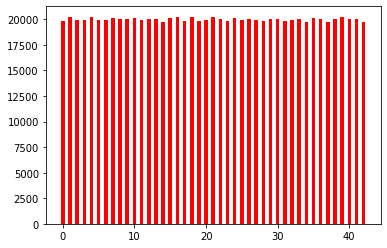

In [ ]:
#Augmentation #데이터 늘리기


train_data_transforms = transforms.Compose([
     transforms.ToPILImage(), 
     transforms.RandomApply([  #이미지 돌리기
       transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
       transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
       transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC), 
       transforms.RandomAffine(0, scale=(0.8, 1.2), resample= PIL.Image.BICUBIC)
                             
     ]),
     transforms.ToTensor()                                       
])



test_data_transforms = transforms.ToTensor()


train_dataset = extend_dataset(PickledDataset(training_file,  transform= test_data_transforms))

n_train = len(train_dataset.features)
n_classes = len(set(train_dataset.labels))
n_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype = torch.int64)


    
class_sample_count = np.bincount(train_dataset.labels) #숫자 분포  빈도수 체크

weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels]) #data 분포를 가중치로 표현

samp = sampler.WeightedRandomSampler(weights, 43*20000) #(weights, num_samples, replacement=True, generator=None)

train_loader = WrappendDataLoader(DataLoader(train_dataset, batch_size=64, sampler= samp), to_device)

balanced_y_train = torch.LongTensor([]).to(device)
with torch.no_grad():
  for _, y in train_loader:
    balanced_y_train = torch.cat((balanced_y_train, y)) #합치기 

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color = 'r')
plt.show()





In [ ]:



valid_dataset = PickledDataset(validation_file, transform= test_data_transforms)
test_dataset = PickledDataset(testing_file, transform= test_data_transforms)


train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

n_train = len(train_dataset)
n_epochs = 20



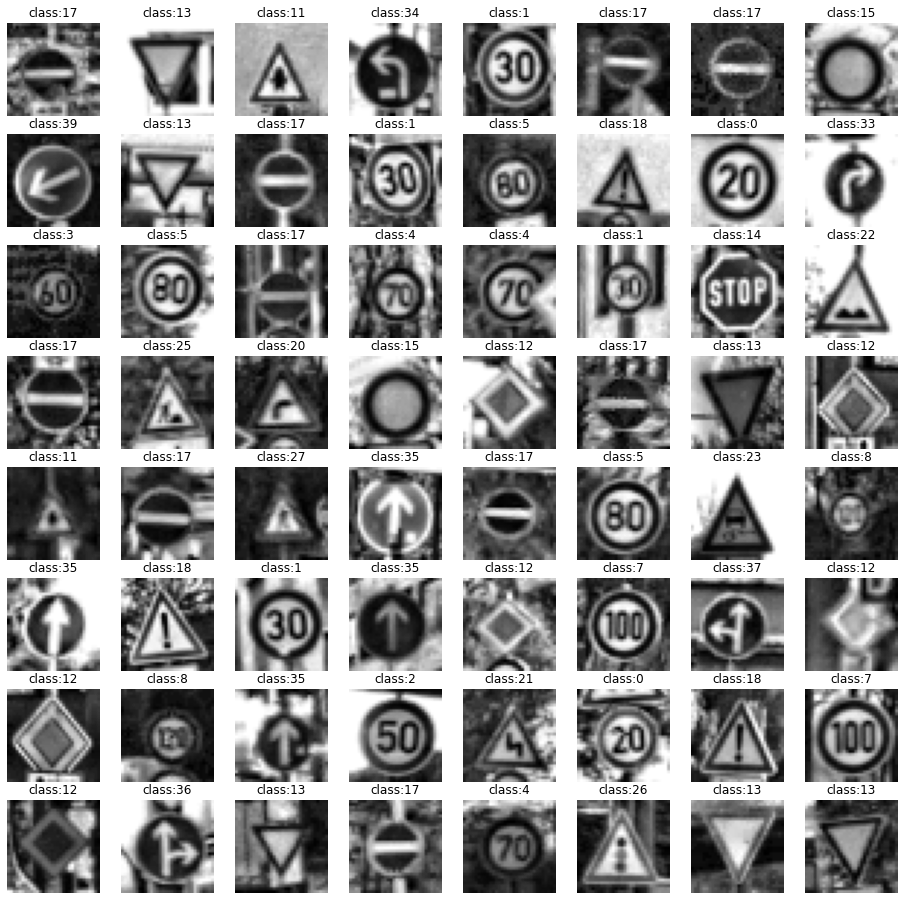

In [ ]:
def convert_image_np(img):
  img = img.numpy().transpose((1, 2, 0)).squeeze()
  return img


with torch.no_grad():
  x, y = next(iter(train_loader))
  plt.figure(figsize= (16, 16))
  for i in range(len(y)):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.title('class:{}'.format(y[i]))
    plt.imshow(convert_image_np(x[i].cpu()), cmap = 'gray')

In [ ]:
model = BaselineNet(gray= True).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)


[Epoch 1/20] Train loss: 3.535131	Validation loss: 3.633565	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.371498	Validation loss: 3.588037	 Validation accruacy: 6.825%
[Epoch 3/20] Train loss: 2.656978	Validation loss: 2.161634	 Validation accruacy: 41.587%
[Epoch 4/20] Train loss: 1.274603	Validation loss: 1.228451	 Validation accruacy: 65.397%
[Epoch 5/20] Train loss: 0.797640	Validation loss: 0.894552	 Validation accruacy: 74.785%
[Epoch 6/20] Train loss: 0.587247	Validation loss: 0.699038	 Validation accruacy: 78.889%
[Epoch 7/20] Train loss: 0.456769	Validation loss: 0.604606	 Validation accruacy: 82.268%
[Epoch 8/20] Train loss: 0.371220	Validation loss: 0.514908	 Validation accruacy: 85.510%
[Epoch 9/20] Train loss: 0.310404	Validation loss: 0.530082	 Validation accruacy: 85.215%
[Epoch 10/20] Train loss: 0.261131	Validation loss: 0.426490	 Validation accruacy: 88.141%
[Epoch 11/20] Train loss: 0.224122	Validation loss: 0.410533	 Validation accruacy: 88.707%
[Epoch 12/

In [ ]:
#Model

class TrafficSignNet(nn.Module):
  def __init__(self):
    super(TrafficSignNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 100, 5)
    self.conv1_bn = nn.BatchNorm2d(100) #학습과정을 안전, 속도 
    self.pool = nn.MaxPool2d(2, 2)
    
    self.conv2 = nn.Conv2d(100, 150, 3)
    self.conv2_bn = nn.BatchNorm2d(150)
    
    self.conv3 = nn.Conv2d(150, 250, 1)
    self.conv3_bn = nn.BatchNorm2d(250)


    self.fc1 = nn.Linear(250*3*3, 350)
    self.fc1_bn = nn.BatchNorm1d(350)
    
    self.fc2 = nn.Linear(350, 43)


    self.dropout = nn.Dropout(p = 0.5)



  def forward(self, x):
      x = self.pool(F.elu(self.conv1(x)))
      x = self.dropout(self.conv1_bn(x))
      x = self.pool(F.elu(self.conv2(x)))
      x = self.dropout(self.conv2_bn(x))
      x = self.pool(F.elu(self.conv3(x)))
      x = self.dropout(self.conv3_bn(x))
      x = x.view(-1, 250 * 3 * 3)
      x = F.elu(self.fc1(x))
      x = self.dropout(self.fc1_bn(x))
      x = self.fc2(x)
      return x


In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience = 10):
  wait = 0
  valid_loss_min = np.Inf


  for epoch in range(epochs):
      
      #Train model
      model.train()
      losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
      train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
      
      #Validation model
      model.eval()
      with torch.no_grad():
          losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
          valid_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
          valid_accuracy = np.sum(corrects) / np.sum(nums)*100
          print(f"[Epoch {epoch+1}/{epochs}] "
                f"Train loss: {train_loss:.6f}\t"
                f"Validation loss: {valid_loss:.6f}\t",
                f"Validation accruacy: {valid_accuracy:.3f}%")    
          
          # Savw model if validation loss has decreased 
          if valid_loss <= valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.6f} -->{valid_loss:.6f}  ).Saving model ...")
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            wait = 0
          else:
            wait += 1
            if wait>=  patience:
              print(f"Terminated Training for Early Stopping at Epoch{epoch+1} ")
              return 
              

In [ ]:
n_epochs = 10
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/10] Train loss: 1.702134	Validation loss: 1.025168	 Validation accruacy: 71.247%
Validation loss decreased (inf -->1.025168  ).Saving model ...
[Epoch 2/10] Train loss: 0.680562	Validation loss: 0.548763	 Validation accruacy: 84.875%
Validation loss decreased (1.025168 -->0.548763  ).Saving model ...
[Epoch 3/10] Train loss: 0.411563	Validation loss: 0.342019	 Validation accruacy: 90.113%
Validation loss decreased (0.548763 -->0.342019  ).Saving model ...
[Epoch 4/10] Train loss: 0.281495	Validation loss: 0.243470	 Validation accruacy: 92.993%
Validation loss decreased (0.342019 -->0.243470  ).Saving model ...
[Epoch 5/10] Train loss: 0.211104	Validation loss: 0.193984	 Validation accruacy: 94.376%
Validation loss decreased (0.243470 -->0.193984  ).Saving model ...
[Epoch 6/10] Train loss: 0.167445	Validation loss: 0.152215	 Validation accruacy: 95.941%
Validation loss decreased (0.193984 -->0.152215  ).Saving model ...
[Epoch 7/10] Train loss: 0.138766	Validation loss: 0.1300

In [ ]:
check_point = torch.load('model.pt', map_location= device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.118326	Test accruacy: 96.619%
